# A/B testing- project description

This project is a joint intiative of the data analysis and the marketing departments of a big online store.
Together we have compiled a list of hypotheses that we hope may help boost revenue.
The list includes 9 hypotheses regarding ways to do so.
Our first goal was to calculate and find possible ways to prioritize some of the hypotheses in this list. 
Following doing so, A/B tests were conducted through-out the 31 days of August 2019. 
The results were saved to 2 datasets: orders and visits. 
The visits dataset included the daily data about: date, group and number of visits (62 rows of data, 31 per group).
The order  dataset included un-aggragated data: date, group, visitorID, transactionID and revenue (1197 rows).
Each dataset, hence, included data about both- the control group (A) and the test group (B).

In the next part of the project, data was pre-processed. we changed data-types to better suit our goals, and also removed from the dataset users that were accidentaly exposed to both conditions.
Next, we identified values of the relevant measures (order size and number of orders) which we suspected were abnormal outliers, and decided to remove them using a mild cut-off point of the 99th percentile.

In the last part of the project, our goal was to assess whether the intervention performed on group B (the test group) yielded better results than the existing results achieved via the condition of group A (the control group). 
We chose two metrices:
- The conversion rate
- The average order size

Results and conclusions will be provided in the conclusion section.

### Loading libraries and data:

In [1]:
pip install -U kaleido

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import math as mth
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
try:
    orders = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Making Business Decisions Based on Data\A-B testing project\orders_us.csv")
    visits = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Making Business Decisions Based on Data\A-B testing project\visits_us.csv")
    hypo = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Making Business Decisions Based on Data\A-B testing project\hypotheses_us.csv", sep=';')
    
except:
    orders = pd.read_csv("/datasets/orders_us.csv")
    visits = pd.read_csv("/datasets/visits_us.csv")
    hypo = pd.read_csv("/datasets/hypotheses_us.csv", sep=';')

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
# exploring tables:
print ('hypotheses table')
hypo
print()
print ('visits table')
visits.head()
print()
print ('orders table')
orders.head()

hypotheses table


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5



visits table


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



orders table


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


## Preprocessing:
There might be mistakes in the original
datasets; for example, some of the visitors might have gotten into both group
A and group B.

### Visits:

In [6]:
# looking into the visits table: the dtype of 'date' needs changing
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [7]:
visits['date'] =  pd.to_datetime(visits['date'], format='%Y-%m-%d') 
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
# learning the table: during the month (8/2019) there were 31 daily registrations per group
visits['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [9]:
visits.duplicated().sum()

0

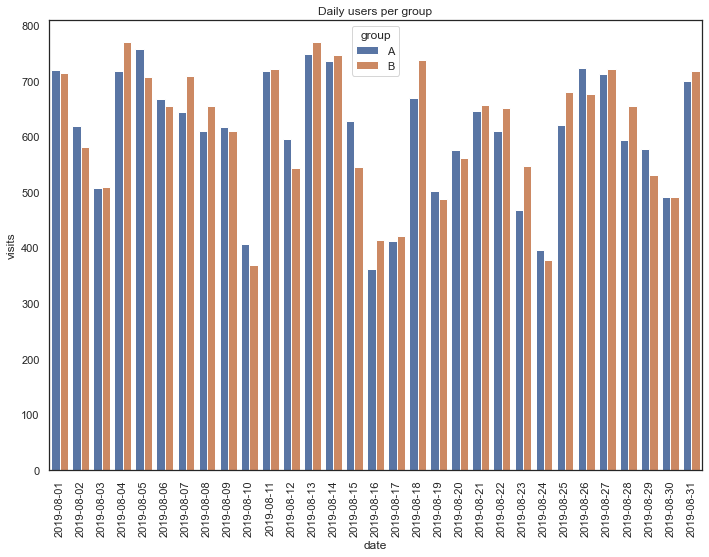

In [10]:
# comparing the number of visitors per day between the two groups, throughout the month:
# creating a grouped bar plot for the two groups:

sns.set(style='white', rc={'figure.figsize':(11.7,8.27)})      
graph = sns.barplot(x=visits['date'].dt.strftime('%Y-%m-%d'), y='visits', hue='group', data=visits).set(title="Daily users per group")
plt.xticks(rotation=90);


The bar-plot shows that:
- the number of users varies greatly throughout the month for both groups.
- the lowest number of visitors was registered on 16/8/19 for group A (around 360 visitors), and the highest numbers were both registered for group B (4/8, 13/8)- around 770 visitors.


In [11]:
# looking into descriptive statistics:
visits.groupby('group').describe()


visits                                                           
       count        mean         std    min    25%    50%    75%    max
group                                                                  
A       31.0  604.387097  112.396227  361.0  541.0  619.0  705.0  756.0
B       31.0  610.193548  118.156230  369.0  537.0  654.0  711.0  770.0

In [12]:
# total number of visitors per group
visits.groupby('group')['visits'].sum()

group
A    18736
B    18916
Name: visits, dtype: int64

### Orders:

In [13]:
# the same change is needed in the orders table:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [14]:
# changing the date variable dtype from object to datetime:
orders['date'] =  pd.to_datetime(orders['date'], dayfirst=True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [15]:
# looking for duplicates: (none)
orders.duplicated().sum()

0

In [16]:
#checking if the group assignment is exhaustive and exclusive:
## creating two lists
visitorsA = orders[orders['group'] == 'A']['visitorId']
visitorsB= orders[orders['group'] == 'B']['visitorId']

In [17]:
# finding common elements to the two groups:
common_elements = np.intersect1d(visitorsA, visitorsB)
common_elements

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830], dtype=int64)

In [18]:
# how many common elements are there?
howmany_common = len(common_elements)
howmany_common

58

In [19]:
# Since i can't be sure to which groups these users were really assigned, and maybe they were indeed exposed to both, so i 
#have to drop them, but also save a raw copy for later questions:

orders = orders[~orders['visitorId'].isin(common_elements)]


In [20]:
#checking (ran a few from the 'common_elements' list):
print(4266935830 in orders)    

False


In [21]:
# looking at the table in general reveals a difference in group size, as well as possible outliers (group B):
orders.groupby('group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,468.0,113.700855,171.372117,5.0,20.3,50.1,131.925,1425.8
B,548.0,145.348905,868.228227,5.1,20.8,45.9,125.200,19920.4


### Hypotheses (hypo):

In [22]:
hypo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [23]:
hypo['Hypothesis'] = hypo['Hypothesis'].astype('category') 

In [24]:
hypo.describe()

,Reach,Impact,Confidence,Effort
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


## Part 1. Prioritizing Hypotheses

### Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.

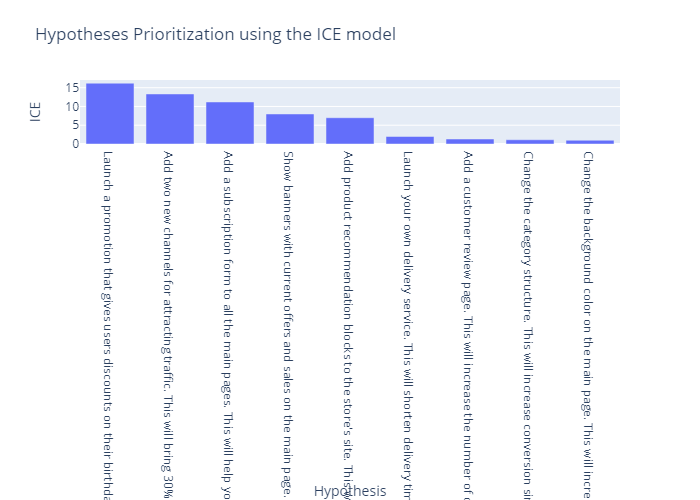

In [25]:
# ICE = (impact*confidence) / effort
hypo['ICE'] = (hypo['Impact'] * hypo['Confidence']) / hypo['Effort']
hypo.sort_values(by='ICE', ascending = False)
fig = px.bar(hypo.sort_values(by='ICE', ascending = False), x="Hypothesis", y="ICE", title="Hypotheses Prioritization using the ICE model")
fig.show("png");

Prioritizing hypotheses using the ICE model suggested that the 3 top ranked hypotheses should be: 
- [8] - Launch a promotion that gives users discounts on their birthdays. 
- [0] - Add two new channels for attracting traffic. This will bring 30% more users.
- [7]- Add a subscription form to all the main pages. This will help you compile a mailing list.

The 3 lowest ranked hypotheses were:
- [4] - Change the background color on the main page. This will increase user engagement.
- [3] - Change the category structure. This will increase conversion since users will find the products they want more quickly.
- [5] - Add a customer review page. This will increase the number of orders.



### Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.

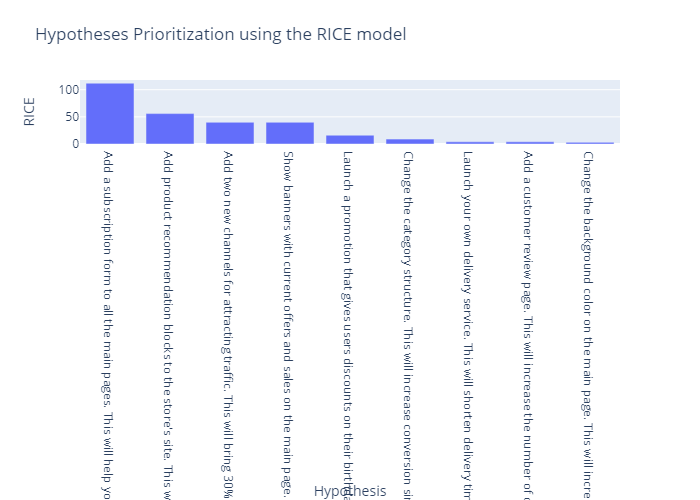

In [26]:
# RICE = (reach * impact * confidence) / effort
hypo['RICE'] = (hypo['Reach'] * hypo['Impact'] * hypo['Confidence']) / hypo['Effort']
hypo.sort_values(by='RICE', ascending = False)
fig = px.bar(hypo.sort_values(by='RICE', ascending = False), x="Hypothesis", y="RICE", title="Hypotheses Prioritization using the RICE model")
fig.show("png");


Prioritizing hypotheses using the RICE model suggested that the 3 top ranked hypotheses should be:

- [7]- Add a subscription form to all the main pages. This will help you compile a mailing list.
- [2] - Add product recommendation blocks to the store's site. This will increase conversion and average purchase size.
- [0] - Add two new channels for attracting traffic. This will bring 30% more users.

The 3 lowest ranked hypotheses were:

- [4] - Change the background color on the main page. This will increase user engagement.
- [5] - Add a customer review page. This will increase the number of orders.
- [1]- Launch your own delivery service. This will shorten delivery time.

### Provide an explanation for the changes.

The two models agree that it would be most effective to prioritize hypotheses indexed as [7] and [0], and rank hypotheses indexed as [4] and [5] very low.
However there are also prioritiztion differences, that stem from the additional parameter: Reach (how many users will be affected by the update you wish to introduce).
- for example:
- Hypothesis [7] states that adding a subscription form will improve revenue. ICE ranks it as #3 while RICE, that takes into account the exposure of users, ranks it as #1. 
- On the other hand, ICE ranks hypothesis [8] ("Launch a promotion that gives users discounts on their birthdays") as #1. RICE, however, ranks it as #5, since birthdays don't occur often enough (in general ;-), but also not enough to make a change. 

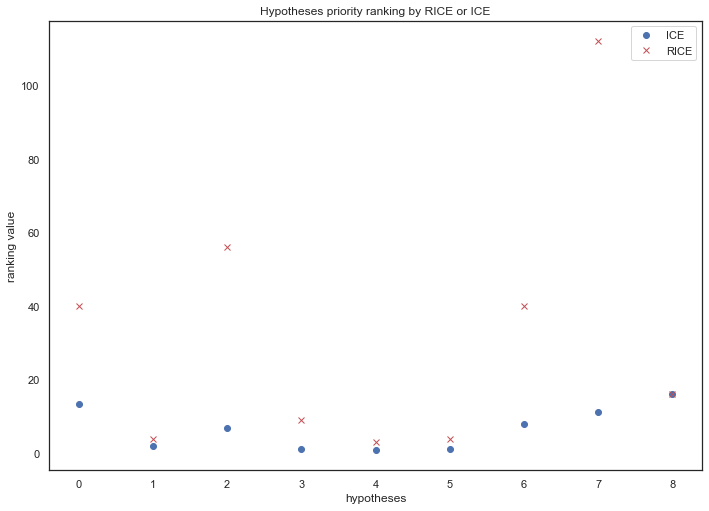

In [27]:
hypo[['ICE', 'RICE']].plot(style=['o','rx'])
plt.xlabel('hypotheses')
plt.ylabel('ranking value')
plt.title('Hypotheses priority ranking by RICE or ICE')
plt.show(); 

## Part 2. A/B Test Analysis

In [28]:
# creating subsets of visits and orders tables, according to test/control group:
orders_A = orders[orders.group == 'A']
orders_B = orders[orders.group == 'B']
visits_A = visits[visits.group == 'A']
visits_B = visits[visits.group == 'B']

 ### 1. Graph cumulative revenue by group. Make conclusions and conjectures.


In [29]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore");

In [30]:
o_A= orders_A[['date', 'revenue']]
o_A= o_A.groupby('date')['revenue'].sum().reset_index()
o_A.columns = ['date', 'daily_rev']
o_A.head()

,date,daily_rev
0,2019-08-01,2266.6
1,2019-08-02,1468.3
2,2019-08-03,1815.2
3,2019-08-04,675.5
4,2019-08-05,1398.0


In [31]:
o_B= orders_B[['date', 'revenue']]
o_B= o_B.groupby('date')['revenue'].sum().reset_index()
o_B.columns = ['date', 'daily_rev']
o_B.head()

,date,daily_rev
0,2019-08-01,967.2
1,2019-08-02,2568.1
2,2019-08-03,1071.6
3,2019-08-04,1531.6
4,2019-08-05,1449.3


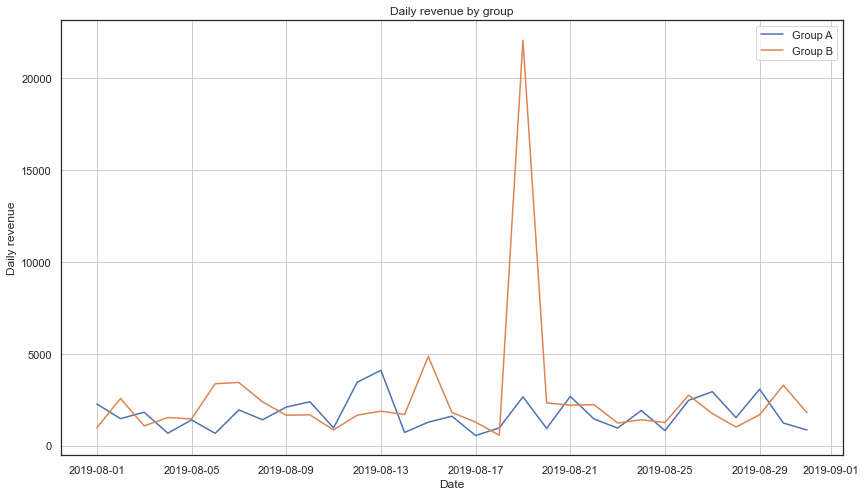

In [32]:
plt.figure(figsize=(14,8))
plt.grid()
plt.title('Daily revenue by group')
plt.plot(o_A['date'], o_A['daily_rev'], label='Group A')
plt.plot(o_B['date'], o_B['daily_rev'], label='Group B')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily revenue')
plt.show();

**The graph illustrates fluctuative sale month for both groups, with an abnormal looking spike for group B on the 19/8.**

In [33]:
# cumulative revenue by group:
o_A['cum_rev'] = o_A['daily_rev'].cumsum()
o_B['cum_rev'] = o_B['daily_rev'].cumsum()

print('Group A')
o_A
print('Group B')
o_B

Group A


,date,daily_rev,cum_rev
0,2019-08-01,2266.6,2266.6
1,2019-08-02,1468.3,3734.9
2,2019-08-03,1815.2,5550.1
3,2019-08-04,675.5,6225.6
4,2019-08-05,1398.0,7623.6
5,2019-08-06,668.4,8292.0
6,2019-08-07,1942.0,10234.0
7,2019-08-08,1404.8,11638.8
8,2019-08-09,2095.2,13734.0
9,2019-08-10,2387.5,16121.5


Group B


,date,daily_rev,cum_rev
0,2019-08-01,967.2,967.2
1,2019-08-02,2568.1,3535.3
2,2019-08-03,1071.6,4606.9
3,2019-08-04,1531.6,6138.5
4,2019-08-05,1449.3,7587.8
5,2019-08-06,3369.3,10957.1
6,2019-08-07,3435.6,14392.7
7,2019-08-08,2379.9,16772.6
8,2019-08-09,1656.2,18428.8
9,2019-08-10,1674.8,20103.6


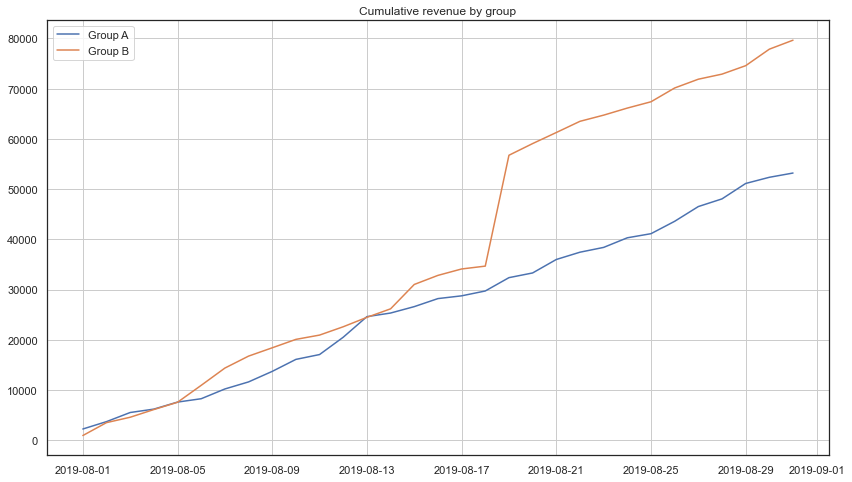

In [34]:
# plot of cumulative revenue by group:
plt.figure(figsize=(14,8))
plt.grid()
plt.title('Cumulative revenue by group')
plt.plot(o_A['date'], o_A['cum_rev'], label='Group A')
plt.plot(o_B['date'], o_B['cum_rev'], label='Group B')
plt.legend()
plt.show();

** **Conclusions: The graph shows that while group A's cumulative revenue climbs up in an expected, linear moderate slope, group B's cumulative revenue has an anomalous behavior, with a steep "jump" in revenue between the 18th and 19th of August. The o_B table shows a very slow day, in terms of sales, on the 18/8 and a very strong and abnormal day on the 19/8. This cannot be explained by the difference in group sizes, and probably indicates the presence of outliers- either a very big/expensive order, or a great number of orders**

### 2. Graph cumulative average order size by group. Make conclusions and conjectures.

In [35]:
# calculating daily orders and revenue for group A:
o_sizeA = orders_A[['date', 'transactionId', 'revenue']]
sizeA = o_sizeA.groupby('date').agg({'transactionId': 'nunique', 'revenue': 'sum'}).reset_index()
sizeA = sizeA.rename(columns={'transactionId': 'daily_orders', 'revenue': 'daily_rev'})
sizeA.head()

,date,daily_orders,daily_rev
0,2019-08-01,23,2266.6
1,2019-08-02,19,1468.3
2,2019-08-03,24,1815.2
3,2019-08-04,11,675.5
4,2019-08-05,22,1398.0


In [36]:
# calculating cumulative average order size for group A:
sizeA['cum_orders'] = sizeA['daily_orders'].cumsum()
sizeA['cum_rev'] = sizeA['daily_rev'].cumsum()
sizeA['cum_order_size'] = sizeA['cum_rev'] / sizeA['cum_orders']
sizeA.head(10)


,date,daily_orders,daily_rev,cum_orders,cum_rev,cum_order_size
0,2019-08-01,23,2266.6,23,2266.6,98.547826
1,2019-08-02,19,1468.3,42,3734.9,88.926190
2,2019-08-03,24,1815.2,66,5550.1,84.092424
3,2019-08-04,11,675.5,77,6225.6,80.851948
4,2019-08-05,22,1398.0,99,7623.6,77.006061
5,2019-08-06,15,668.4,114,8292.0,72.736842
6,2019-08-07,16,1942.0,130,10234.0,78.723077
7,2019-08-08,14,1404.8,144,11638.8,80.825000
8,2019-08-09,11,2095.2,155,13734.0,88.606452
9,2019-08-10,15,2387.5,170,16121.5,94.832353


In [37]:
# the same for group B:
o_sizeB = orders_B[['date', 'transactionId', 'revenue']]
sizeB = o_sizeB.groupby('date').agg({'transactionId': 'nunique', 'revenue': 'sum'}).reset_index()
sizeB = sizeB.rename(columns={'transactionId': 'daily_orders', 'revenue': 'daily_rev'})
sizeB.head()

,date,daily_orders,daily_rev
0,2019-08-01,17,967.2
1,2019-08-02,23,2568.1
2,2019-08-03,14,1071.6
3,2019-08-04,14,1531.6
4,2019-08-05,21,1449.3


In [38]:
sizeB['cum_orders'] = sizeB['daily_orders'].cumsum()
sizeB['cum_rev'] = sizeB['daily_rev'].cumsum()
sizeB['cum_order_size'] = sizeB['cum_rev'] / sizeB['cum_orders']
sizeB
#.head(10)

,date,daily_orders,daily_rev,cum_orders,cum_rev,cum_order_size
0,2019-08-01,17,967.2,17,967.2,56.894118
1,2019-08-02,23,2568.1,40,3535.3,88.382500
2,2019-08-03,14,1071.6,54,4606.9,85.312963
3,2019-08-04,14,1531.6,68,6138.5,90.272059
4,2019-08-05,21,1449.3,89,7587.8,85.256180
5,2019-08-06,23,3369.3,112,10957.1,97.831250
6,2019-08-07,23,3435.6,135,14392.7,106.612593
7,2019-08-08,22,2379.9,157,16772.6,106.831847
8,2019-08-09,19,1656.2,176,18428.8,104.709091
9,2019-08-10,22,1674.8,198,20103.6,101.533333


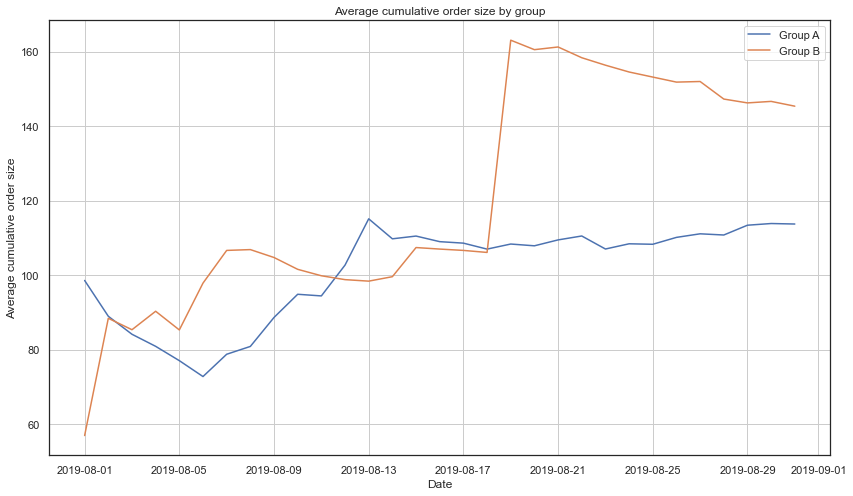

In [39]:
# plotting the average cumulative order size by group:
plt.figure(figsize=(14,8))
plt.grid()
plt.title('Average cumulative order size by group')
plt.plot(sizeA['date'], sizeA['cum_order_size'], label='Group A')
plt.plot(sizeB['date'], sizeB['cum_order_size'], label='Group B')
plt.xlabel('Date')
plt.ylabel('Average cumulative order size')
plt.legend()
plt.show();

#### Conclusions: Through-out the month, the two groups have different trajectories. 
**Group A's cumulative order size** starts in a higher position compared to group B, but then drops at the first week until the 7/8 . During the second week we see a clear and somewhat linear climb in order sizes until it peaks at the 13/8. From this point on the graph seems to stablize with a slight positive tendency.
**Group B's cumulative order size** follows a different path: Sales on the first day are very low, but rapidly rise. 
During the next 10 days, there is a clear and strong positive tendency, despite substantial fluctuation in order size. During the second week there is a somewhat more stable pattern of order size around 99$-107$, with a slight negative tendency.On the 19/8 We see a prominant rise in order sizes, adding almost 54% to the cumulative order size. From this point to the end of the week, there is a moderate and stable fall in order size.




### 3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

In [40]:
# Gathering the data into one DataFrame
mergeddata = sizeA.merge(sizeB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergeddata.head()

,date,daily_ordersA,daily_revA,cum_ordersA,cum_revA,cum_order_sizeA,daily_ordersB,daily_revB,cum_ordersB,cum_revB,cum_order_sizeB
0,2019-08-01,23,2266.6,23,2266.6,98.547826,17,967.2,17,967.2,56.894118
1,2019-08-02,19,1468.3,42,3734.9,88.926190,23,2568.1,40,3535.3,88.382500
2,2019-08-03,24,1815.2,66,5550.1,84.092424,14,1071.6,54,4606.9,85.312963
3,2019-08-04,11,675.5,77,6225.6,80.851948,14,1531.6,68,6138.5,90.272059
4,2019-08-05,22,1398.0,99,7623.6,77.006061,21,1449.3,89,7587.8,85.256180


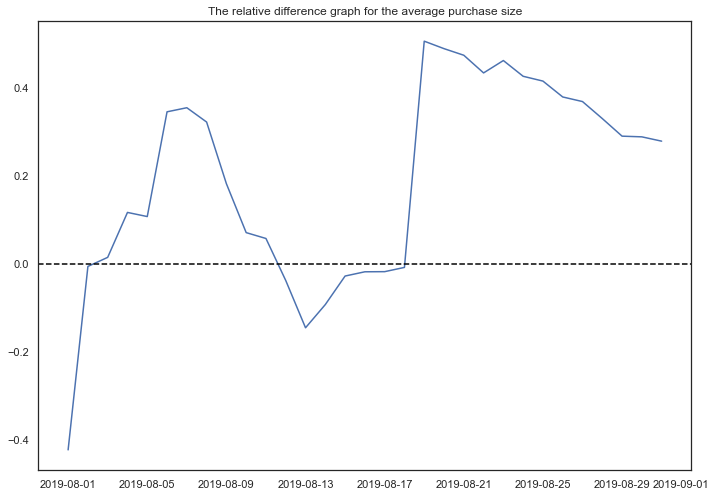

In [41]:
# Plotting a relative difference graph for the average purchase sizes
plt.plot(mergeddata['date'], (mergeddata['cum_order_sizeB']/mergeddata['cum_order_sizeA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("The relative difference graph for the average purchase size");

#### Conclusions: The relative difference graph shows that during most of the month group B took the lead in terms of order sizes. However, since at several points the difference between the groups spike it might be indicative of some big orders and outliers.

### 4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

In [42]:
# merging tables to get data on number of visits:
vo_A = sizeA.merge(visits_A, on='date', how='left')
vo_B = sizeB.merge(visits_B, on='date', how='left')


In [43]:
# calculating conversion rates:
vo_A['cv'] = vo_A['daily_orders'] / vo_A['visits']
vo_B['cv'] = vo_B['daily_orders'] / vo_B['visits']
vo_A.head()
vo_B.head()

,date,daily_orders,daily_rev,cum_orders,cum_rev,cum_order_size,group,visits,cv
0,2019-08-01,23,2266.6,23,2266.6,98.547826,A,719,0.031989
1,2019-08-02,19,1468.3,42,3734.9,88.926190,A,619,0.030695
2,2019-08-03,24,1815.2,66,5550.1,84.092424,A,507,0.047337
3,2019-08-04,11,675.5,77,6225.6,80.851948,A,717,0.015342
4,2019-08-05,22,1398.0,99,7623.6,77.006061,A,756,0.029101


,date,daily_orders,daily_rev,cum_orders,cum_rev,cum_order_size,group,visits,cv
0,2019-08-01,17,967.2,17,967.2,56.894118,B,713,0.023843
1,2019-08-02,23,2568.1,40,3535.3,88.382500,B,581,0.039587
2,2019-08-03,14,1071.6,54,4606.9,85.312963,B,509,0.027505
3,2019-08-04,14,1531.6,68,6138.5,90.272059,B,770,0.018182
4,2019-08-05,21,1449.3,89,7587.8,85.256180,B,707,0.029703


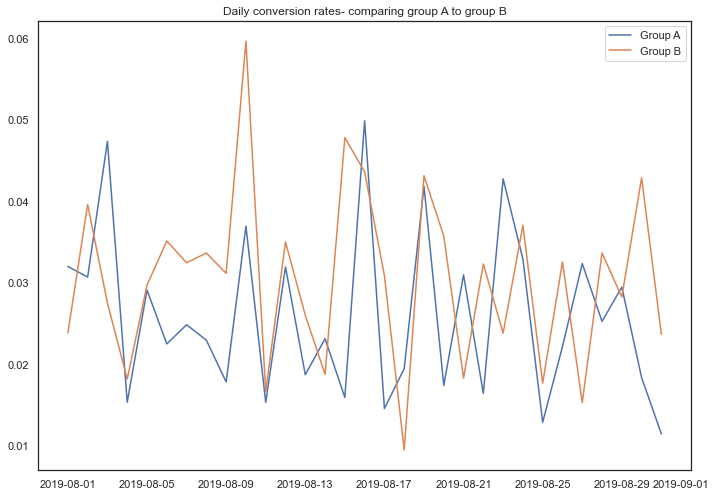

In [44]:
plt.plot(vo_A['date'], vo_A['cv'], label='Group A')
plt.plot(vo_B['date'], vo_B['cv'], label='Group B')
plt.title("Daily conversion rates- comparing group A to group B")
plt.legend();

In [45]:
#overall conversion:
print ("overall conversion rate for group A:", vo_A['daily_orders'].sum()/vo_A['visits'].sum())
print ("overall conversion rate for group B:", vo_B['daily_orders'].sum()/vo_B['visits'].sum())

overall conversion rate for group A: 0.02497865072587532
overall conversion rate for group B: 0.02897018397124128


#### Conclusions: **The graph depicts the daily convergance rate of both groups: In general, it shows very low conversion rates for both groups with a somewhat similar pattern of fluctuation. The overall conversion rates are similar as well, which means that out of a lot of users only a small amount become buyers.**

#### plot a relative difference graph for the cumulative conversion rates

In [46]:
# creating a cumulative visit column:
vo_A['cum_visits'] = vo_A['visits'].cumsum()
vo_B['cum_visits'] = vo_B['visits'].cumsum()

In [47]:
# calculating the cumulative conversion rates:
vo_A['cum_cv'] = vo_A['cum_orders'] / vo_A['cum_visits']
vo_B['cum_cv'] = vo_B['cum_orders'] / vo_B['cum_visits']
print("Group A")
vo_A[['date', 'cum_cv']].head(7)
print("Group B")
vo_B[['date', 'cum_cv']].head(7)

Group A


,date,cum_cv
0,2019-08-01,0.031989
1,2019-08-02,0.031390
2,2019-08-03,0.035772
3,2019-08-04,0.030055
4,2019-08-05,0.029837
5,2019-08-06,0.028607
6,2019-08-07,0.028084


Group B


,date,cum_cv
0,2019-08-01,0.023843
1,2019-08-02,0.030912
2,2019-08-03,0.029950
3,2019-08-04,0.026428
4,2019-08-05,0.027134
5,2019-08-06,0.028463
6,2019-08-07,0.029070


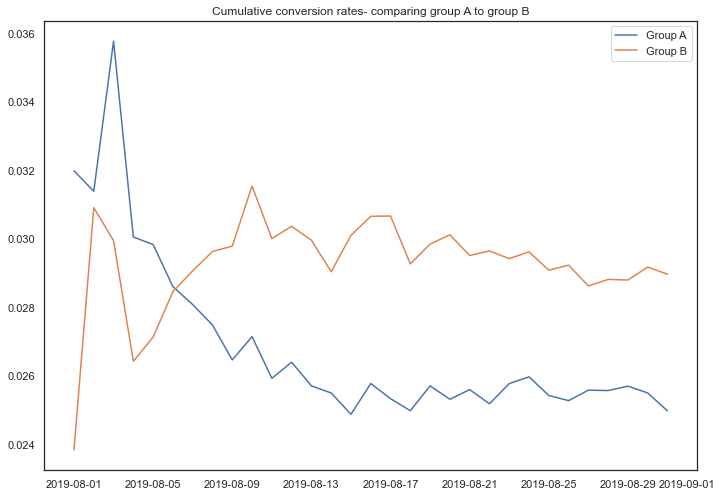

In [48]:
# plotting Cumulative conversion rate graphs for the two groups
plt.plot(vo_A['date'], vo_A['cum_cv'], label='Group A')
plt.plot(vo_B['date'], vo_B['cum_cv'], label='Group B')
plt.title("Cumulative conversion rates- comparing group A to group B")
plt.legend();

**Graph interpretation: The cumulative converion rates of the two groups is low, but they follow different paths. 
- Group A peaks on the 3rd of Aug (cum_conversion= 0.036), and then drops steadily for about 10 days, and stabilizes on a lower value of aroung 0.025.
- Group B peaks on the second of Aug in a lower cum. conversion rate than group A (0.031), but then drops and rises to a higher level, stabilizing at around 0.029 (higher than group A)**


In [49]:
# towards a relative difference graph- Gmerging datasets:
cum_cv_merged = vo_A.merge(vo_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
cum_cv_merged.head()


,date,daily_ordersA,daily_revA,cum_ordersA,cum_revA,cum_order_sizeA,groupA,visitsA,cvA,cum_visitsA,...,daily_ordersB,daily_revB,cum_ordersB,cum_revB,cum_order_sizeB,groupB,visitsB,cvB,cum_visitsB,cum_cvB
0,2019-08-01,23,2266.6,23,2266.6,98.547826,A,719,0.031989,719,...,17,967.2,17,967.2,56.894118,B,713,0.023843,713,0.023843
1,2019-08-02,19,1468.3,42,3734.9,88.926190,A,619,0.030695,1338,...,23,2568.1,40,3535.3,88.382500,B,581,0.039587,1294,0.030912
2,2019-08-03,24,1815.2,66,5550.1,84.092424,A,507,0.047337,1845,...,14,1071.6,54,4606.9,85.312963,B,509,0.027505,1803,0.029950
3,2019-08-04,11,675.5,77,6225.6,80.851948,A,717,0.015342,2562,...,14,1531.6,68,6138.5,90.272059,B,770,0.018182,2573,0.026428
4,2019-08-05,22,1398.0,99,7623.6,77.006061,A,756,0.029101,3318,...,21,1449.3,89,7587.8,85.256180,B,707,0.029703,3280,0.027134


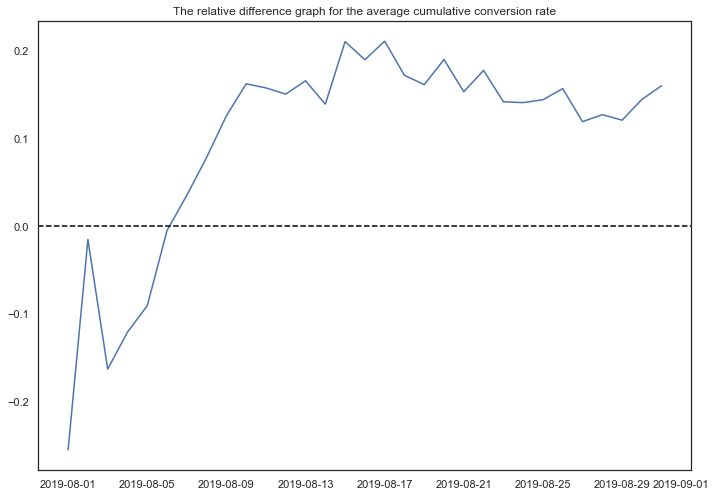

In [50]:
# Plotting a relative difference graph for the cumulative conversion
plt.plot(cum_cv_merged['date'], (cum_cv_merged['cum_cvB']/cum_cv_merged['cum_cvA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("The relative difference graph for the average cumulative conversion rate");

**The relative difference graph adds to the previous cumulative conversion, by illustrating how group B, starting from about a week into the experiment, takes the lead and shows about 20% higher conversion rates compared to group A.**

### 5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures. 

In [51]:
# Group A:
ordersByUsersA = (
    orders_A.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']
print(ordersByUsersA.sort_values(by='orders', ascending=False).head(10))


      visitorId  orders
58    611059232       3
211  2108163459       3
310  2988190573       3
409  3908431265       3
416  3967698036       3
302  2892265953       2
374  3469608676       2
72    759473111       2
286  2744017357       2
282  2733145037       2


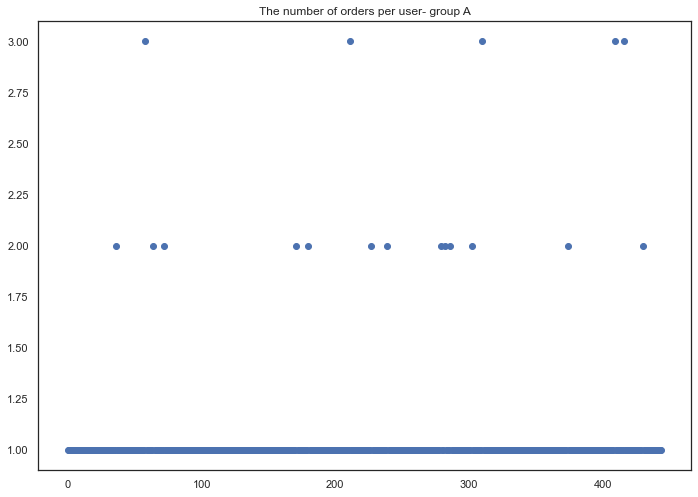

In [52]:
# scatter plot
x_values = pd.Series(range(0,len(ordersByUsersA)))
plt.scatter(x_values, ordersByUsersA['orders']) 
plt.title("The number of orders per user- group A");

In [53]:
# Group B:
ordersByUsersB = (
    orders_B.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']
print(ordersByUsersB.sort_values(by='orders', ascending=False).head(10))

      visitorId  orders
347  2742574263       3
33    249864742       3
486  3935952912       2
256  2025197455       2
418  3332057097       2
51    406208401       2
507  4134830387       2
250  1985475298       2
296  2366521417       2
421  3362039251       2


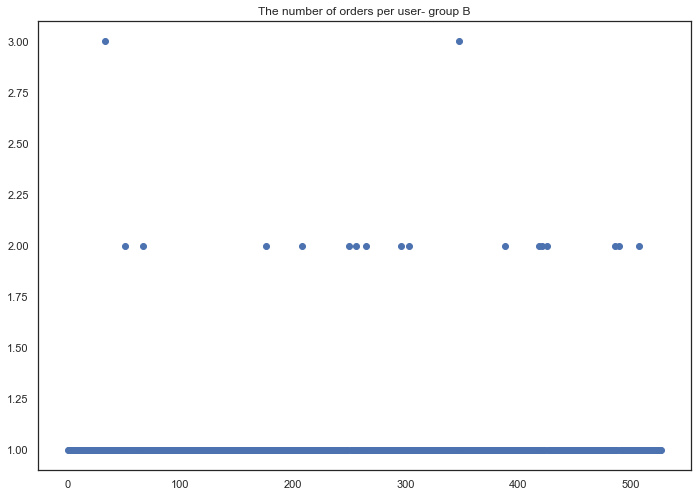

In [54]:
# scatter plot
x_values = pd.Series(range(0,len(ordersByUsersB)))
plt.scatter(x_values, ordersByUsersB['orders']) 
plt.title("The number of orders per user- group B");

**Conclusions- For both groups, the graphs show that most users place one order, a small number of users place 2 orders, and only a few- 3 orders. These do not seem to be big or abnormal numbers, but since i don't know much about the products being sold- i will consider 3 orders a month to be abnormal.**

### 6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [55]:
# Group A:
print(np.percentile(ordersByUsersA['orders'], [95, 99])) 

[1.   2.56]


In [56]:
# Group B:
print(np.percentile(ordersByUsersB['orders'], [95, 99])) 

[1. 2.]


**On average, only 1% of the users in both groups placed more than 2 orders (an average of 2.56 for group A, and 2 for group B). This finding strengthens the one seen in the scatter plot, and suggests it would be wise to define orders=3 as an outlier.**

### 7. Plot a scatter chart of order prices. Make conclusions and conjectures.

In [57]:
orders_A.head()

,transactionId,visitorId,date,revenue,group
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A
14,3859315276,1565034404,2019-08-15,170.9,A


In [58]:
# Group A:
orders_A['revenue'].sort_values(ascending = False).head(10)

1136    1425.8
743     1050.0
1103    1025.8
1099    1015.9
949      930.0
131      830.3
287      830.3
1006     815.8
1137     810.4
746      765.5
Name: revenue, dtype: float64

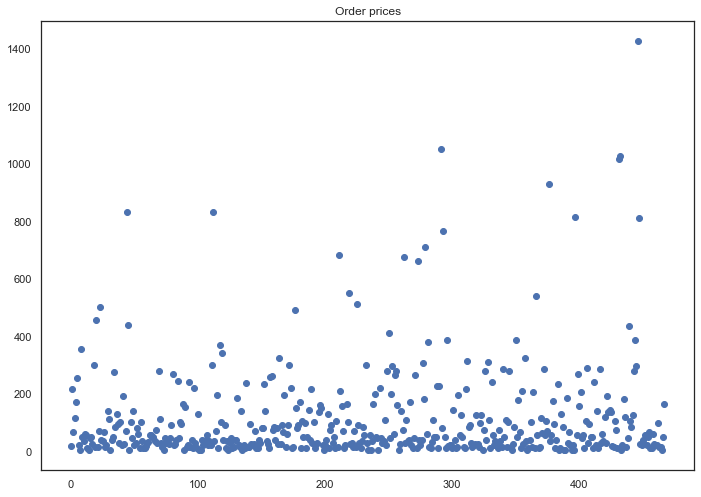

In [59]:
# scatter plot:
x_values = pd.Series(range(0, len(orders_A['revenue'])))
plt.scatter(x_values, orders_A['revenue'])
plt.title("Order prices");


**order size in group A seems normal- most order sizes are between 3 and 300$. Possible outliers are seen above 600$ (I presume)**

In [60]:
# Group B:
orders_B['revenue'].sort_values(ascending = False).head(10)

425     19920.4
1196     3120.1
744      1335.6
940       905.8
613       830.3
1142      815.8
755       705.3
339       640.7
78        630.8
1087      610.7
Name: revenue, dtype: float64

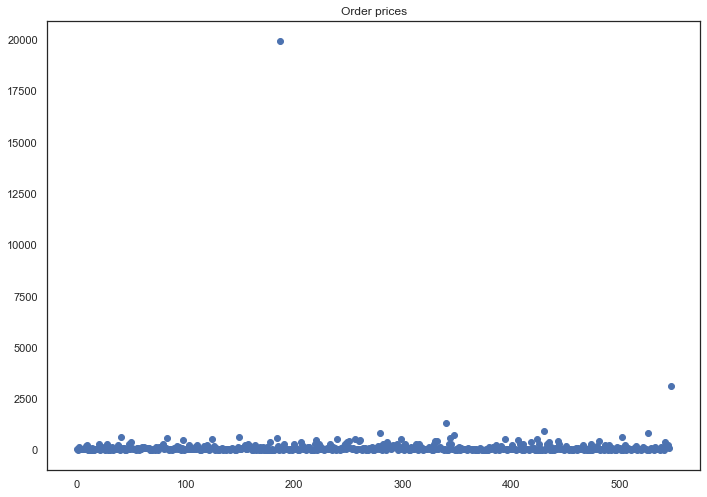

In [61]:
# scatter plot:
x_values = pd.Series(range(0, len(orders_B['revenue'])))
plt.scatter(x_values, orders_B['revenue'])
plt.title("Order prices");

**In group B there is a very distinct and abnormal order size (=19920.4) as well as at 3120$. I would like to narrow the range of values on yaxis and see what the distribution looks like when it isn't masked by the wide range of values:**

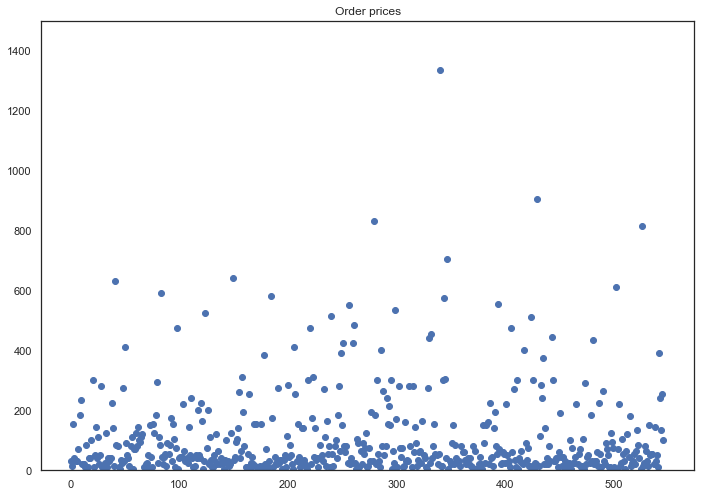

In [62]:
# running the same scatter with a limited range:
x_values = pd.Series(range(0, len(orders_B['revenue'])))
plt.scatter(x_values, orders_B['revenue'])
plt.title("Order prices")
plt.ylim(0, 1500);

** The scatter plot suggest that Group B's order sizes turn abnormal at around 700 $. But percentile calculation would be more accurate.**

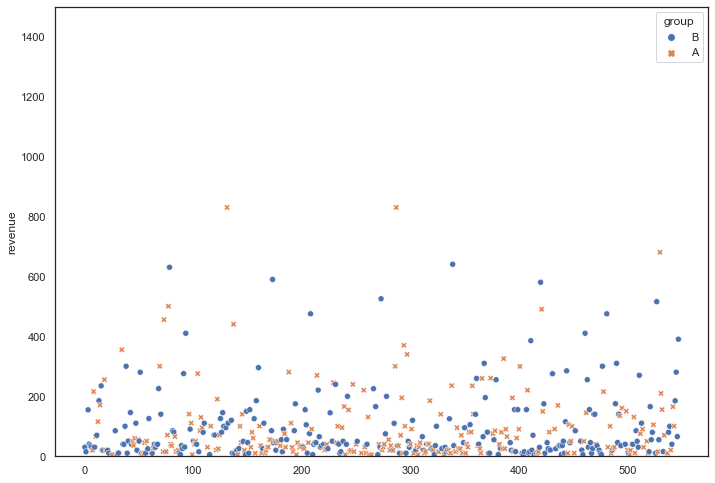

In [63]:
x_values = pd.Series(range(0, len(orders_B['revenue'])))
sns.scatterplot(data=orders, x=x_values, y="revenue", hue="group", style='group')
plt.ylim(0, 1500);


### 8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [64]:
print("Group A-  95th, 97th and 99th percentiles of order prices:")
print(np.percentile(orders_A['revenue'], [95, 97, 99])) 
print()
print("Group B-  95th, 97th and 99th percentiles of order prices:")
print(np.percentile(orders_B['revenue'], [95, 97, 99]))

Group A-  95th, 97th and 99th percentiles of order prices:
[385.63  550.794 863.201]

Group B-  95th, 97th and 99th percentiles of order prices:
[425.795 521.623 763.865]


**# Since i don't know anything about the products being sold, i decided to define the 99th percentile as a cut-off point for both groups:**
- Group A: 863
- Group B: 764

In [65]:
# defining the abnormal users with code (number of orders + order size):
cutoff_manyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2.56]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
cutoff_expensiveOrders = pd.concat([orders_A[orders_A['revenue'] > 863]['visitorId'], orders_B[orders_B['revenue'] > 764]['visitorId']], axis=0)

abnormalUsers = pd.concat([cutoff_manyOrders, cutoff_expensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers)
print(abnormalUsers.shape) 


1099     148427295
33       249864742
58       611059232
949      887908475
744      888512513
1103    1164614297
1136    1307669133
425     1920142716
1196    2108080724
211     2108163459
1142    2606908679
347     2742574263
310     2988190573
409     3908431265
613     3931967268
416     3967698036
940     4003628586
743     4133034833
Name: visitorId, dtype: int64
(18,)


### 9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

**H0 (Null)**: Group A and group B have the same conversion rates- There is no statistically significant difference between them.

**H1 (Alternative)**: Following intervention in group B, the conversion rate of group B will be higher than the one of group A.

**Test selection:** A two sample Z-test for Proportions.

**Rational:** this test is used to check if two samples are drawn from the same population. It is utilized when the population proportion is unknown, as in out case, and it uses the standard normal distribution to calculate the test statistic.
- Since it is a one sided hypothesis, I chose to decrease the alpha by half.

In [66]:
# (A reminder for me...)
visits_A.head(2)
orders_A.head(2)

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619


,transactionId,visitorId,date,revenue,group
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A


In [67]:
# Preparing the relevant variables to perform a proportions z-test:
vis_A = visits_A['visits'].sum()
buy_A = orders_A['visitorId'].count()
vis_B = visits_B['visits'].sum()
buy_B = orders_B['visitorId'].count()

print("Group A:")
print("  VisitorsA", vis_A)
print("  BuyersA", buy_A)
print()
print("Group B:")
print("  VisitorsB", vis_B)
print("  BuyersB", buy_B)

Group A:
  VisitorsA 18736
  BuyersA 468

Group B:
  VisitorsB 18916
  BuyersB 548


In [68]:
# Since the conversion metric is a proportional one (buyes/visitors) there is no need to make the group sizes equal.
alpha = .05 / 2
stat1, pval1 = proportions_ztest([buy_A,buy_B], [vis_A,vis_B])
print('P-Value:{0:0.3f}'.format(pval1))
if (pval1 < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between conversion rates")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the conversion rates different") 
print ("Group A conversion rate:{0:0.3f}".format(buy_A/vis_A))
print ("Group B conversion rate:{0:0.3f}".format(buy_B/vis_B))

P-Value:0.017
Rejecting the null hypothesis: there is a significant difference between conversion rates
Group A conversion rate:0.025
Group B conversion rate:0.029


***Given the sample size, such a difference between the proportions (conversion rates) is enough to conclude that there is a statistically significant difference, although it doesn't seem so at first glance.**

### 10. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

- After filtering the outliers from both groups, the hypothesis hasn't changed:

H0 (Null): Group A and group B have the same conversion rates- There is no statistically significant difference between them.

H1 (Alternative): Following intervention in group B, the conversion rate of group B will be higher than the one of group A.

Test selection: A two sample Z-test for Proportions.


In [69]:
# filtering the abnormal data out of the samples:
orders_A_fil = orders_A[~orders_A['visitorId'].isin(abnormalUsers)]
orders_B_fil = orders_B[~orders_B['visitorId'].isin(abnormalUsers)]

In [70]:
# Re-defining the test variables:
vis_A = visits_A['visits'].sum()
buy_A_fil = orders_A_fil['visitorId'].count()
vis_B = visits_B['visits'].sum()
buy_B_fil = orders_B_fil['visitorId'].count()

print("Group A:")
print("  VisitorsA", vis_A)
print("  BuyersA", buy_A_fil)
print()
print("Group B:")
print("  VisitorsB", vis_B)
print("  BuyersB", buy_B_fil)

Group A:
  VisitorsA 18736
  BuyersA 448

Group B:
  VisitorsB 18916
  BuyersB 536


In [71]:
# Re-running the test with the filtered data:

stat, pval = proportions_ztest([buy_A_fil,buy_B_fil], [vis_A,vis_B])
print('P-Value:{0:0.3f}'.format(pval))
if (pval < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between conversion rates")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the conversion rates different") 
print ("Group A conversion rate:{0:0.3f}".format(buy_A_fil/vis_A))
print ("Group B conversion rate:{0:0.3f}".format(buy_B_fil/vis_B))


P-Value:0.007
Rejecting the null hypothesis: there is a significant difference between conversion rates
Group A conversion rate:0.024
Group B conversion rate:0.028


**Summary-**
By filtering out the abnormal users, the conversion rate of group A became a (tiny) bit lower, while the one of group B- a tiny bit higher, hence making the P-Value a bit lower (and making the chances of a type 1 error smaller)   

### 11. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

**H0 (Null)**: Group A and group B have the same average order size- There is no statistically significant difference between them.

**H1 (Alternative)**: Following intervention in group B, their average order size is bigger than the one of group A.

**Test selection:** Mann Whitney U test

**Rational:** After checking the distribution type of both samples (=not normal) we had to pick a a-parametric test to check our hypothesis. Mannwhitney is a suitable test:  It checks if the distribution of the dependent variable is the same for the two groups and hence- from the same population.
- Since it is a one sided hypothesis, I chose to decrease the alpha by half.

In [72]:
# checking the normality of the distributions to choose the right statistical test:
# Group A:
alpha = .05 
normality_resultA = st.shapiro(orders_A['revenue'])
p_value = normality_resultA[1] 
print('p-value: ', p_value)
if (p_value < alpha):
    print("Null hypothesis rejected: the distribution of group A is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution of group A seems to be normal") 


p-value:  2.7709587438572045e-31
Null hypothesis rejected: the distribution of group A is not normal


In [73]:
# Group B:
normality_resultB = st.shapiro(orders_B['revenue'])
p_value = normality_resultB[1] 
print('p-value: ', p_value)
if (p_value < alpha):
    print("Null hypothesis rejected: the distribution of group B is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution of group B seems to be normal") 

p-value:  4.203895392974451e-45
Null hypothesis rejected: the distribution of group B is not normal


In [74]:
# Choosing the mannwhitney test as an non-parametric test:
p_value = stats.mannwhitneyu(orders_A['revenue'], orders_B['revenue'])[1]
print('p-value: ', p_value)
if (p_value < (alpha/2)):
    print("Null hypothesis rejected: there is a statistically significant difference between order size of the two groups")
else:
    print("Failed to reject the null hypothesis: the difference between order sizes of the two groups is NOT statistically significant.") 
print("Group A- average order size:", round(orders_A['revenue'].mean(), 3))
print("Group B- average order size:", round(orders_B['revenue'].mean(), 3))
print('The relative difference in average order size between the groups: {0:.3f}'.format(orders_B['revenue'].mean() / orders_A['revenue'].mean()-1)) 


p-value:  0.8622329690015668
Failed to reject the null hypothesis: the difference between order sizes of the two groups is NOT statistically significant.
Group A- average order size: 113.701
Group B- average order size: 145.349
The relative difference in average order size between the groups: 0.278


#### Conclusions:
- The p-value is considerably higher than 0.05, so we can't reject the null hypothesis: There is no statistically significant difference between the average order size of the 2 groups. 
- Nonetheless, the average order size for group B is much larger than it is for group A.

### 12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

**H0 (Null)**: Group A and group B have the same average order size- There is no statistically significant difference between them.

**H1 (Alternative)**: Following intervention in group B, their average order size is bigger than the one of group A.

**Test selection:** Mann Whitney U test

In [75]:
# checking the normality of the distributions to choose the right statistical test:
# Group A_filtered:

normality_result1 = st.shapiro(orders_A_fil['revenue'])
p_value = normality_result1[1] 
print('p-value: ', p_value)
if (p_value < alpha):
    print("Null hypothesis rejected: the distribution of group A is NOT normal")
else:
    print("Failed to reject the null hypothesis: the distribution of group A seems to be normal") 

p-value:  1.2471667503670648e-28
Null hypothesis rejected: the distribution of group A is NOT normal


In [76]:
# Group B filtered:
normality_result2 = st.shapiro(orders_B_fil['revenue'])
p_value = normality_result2[1] 
print('p-value: ', p_value)
if (p_value < alpha):
    print("Null hypothesis rejected: the distribution of group B is NOT normal")
else:
    print("Failed to reject the null hypothesis: the distribution of group B seems to be normal") 

p-value:  6.657268751531677e-30
Null hypothesis rejected: the distribution of group B is NOT normal


In [77]:
# Choosing the mannwhitney test as an non-parametric test with filtered data sets:
p_value = stats.mannwhitneyu(orders_A_fil['revenue'], orders_B_fil['revenue'])[1]
print('p-value: ', p_value)
if (p_value < (alpha/2)):
    print("Null hypothesis rejected: there is a statistically significant difference between order size of the two groups")
else:
    print("Failed to reject the null hypothesis: the difference between order sizes of the two groups is NOT statistically significant.") 
print("Group A- average order size:", round(orders_A_fil['revenue'].mean(), 3))
print("Group B- average order size:", round(orders_B_fil['revenue'].mean(), 3))
print('The relative difference in average order size between the groups: {0:.3f}'.format(orders_B_fil['revenue'].mean() / orders_A_fil['revenue'].mean()-1)) 


p-value:  0.7446416146846341
Failed to reject the null hypothesis: the difference between order sizes of the two groups is NOT statistically significant.
Group A- average order size: 102.896
Group B- average order size: 96.915
The relative difference in average order size between the groups: -0.058


#### Summary: 
It seems that following the removal of the abnormal data, the difference between the groups in order sizes had shrinked, hence staying not statistically significant. Also, In comparison to the analysis of the raw data, it seems that the removal of the abnormal data revealed a somewhat opposite relation between the two groups, with order sizes in group A being slightly higher (though not stat sig) than those of group B.


## Conclusions:


In general. it seems that the intervention performed on group B had an influence only on the conversion rate but not on the average order size. 

*Conversion rates:* despite having very low conversion rates in general (in both groups), the conversion of group B was found to be statistically significant higher than the conversion rate in group A.
From the cumulative conversion rates graph it seems that both groups have reached a stable stage, and fluctuation is not prominent. Also, the relative difference shows a significant gap between the groups. Hence, it seems reasonable to stop running the test and validly reject the null hypothesis.

*Order size:* The difference between the two groups was found to be not statistically significant: the intervention tested did not yield the expected result of increasing the average revenue. It seems that although there were more orders in group B and the ratio of orders per visits was higher, the size of the order was not affected.
 The plot depicting the cumulative order size shows that both groups have stabalized, and here too i suggest resuming the test and accepting the results.

Overall, It seems that the intervention performed on group B was not successful, as it did not lead to higher revenue, even though more users converted to byers. It might be useful to look into the products purchased and see if we can gain additional insights. Maybe the conversion rate was higher for cheaper products, and hence- we should use the intervention assessed here on larger markets.